In [2]:
import seaborn as sns
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as t
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, normalize
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [3]:
# инициализируем спарк-сессию
spark = SparkSession.builder.getOrCreate()

In [3]:
spark

In [3]:
# читаем файл со схемой для правильной загрузки типов данных
df = spark.read.format('csv').option('header', 'true').load('C://Users/Uldum/Downloads/clustering_test_work.csv', inferSchema =True)

In [11]:
df.show(2, vertical=True)

-RECORD 0----------------------------------
 _c0                 | 0                   
 actual_id           | 12013601421         
 period_end          | 2021-02-19 00:00:00 
 num                 | 2                   
 revenue_lastyear    | 17920.0             
 quantity_lastyear   | 4                   
 orders_lastyear     | 1                   
 orders_refund       | 0                   
 ratio_not_dh        | 1.0                 
 ratio_online        | 1.0                 
 ratio_refund        | 0.0                 
 avg_ratio_purchase  | 0.8                 
 quantity_1st_period | 4.0                 
 unigenders          | 1                   
 recency             | 123                 
 aov                 | 17920.0             
-RECORD 1----------------------------------
 _c0                 | 1                   
 actual_id           | 12013601421         
 period_end          | 2021-04-19 00:00:00 
 num                 | 3                   
 revenue_lastyear    | 17920.0  

In [19]:
df.select(F.col('actual_id'), F.col('period_end')).show(5)

+-----------+----------+
|  actual_id|period_end|
+-----------+----------+
|12013601421|2021-02-19|
|12013601421|2021-04-19|
|12013601421|2021-06-19|
|12013601421|2021-08-19|
|12013601421|2021-10-19|
+-----------+----------+
only showing top 5 rows



In [6]:
# подзапрос с фильтрацией
param = 0

subq = df.select(F.col('actual_id'), F.col('period_end'), F.col('aov')).filter(F.col('period_end') == "2022-12-07")\
.filter(F.col('aov') > param)
subq.show(5)

+-----------+----------+-------+
|  actual_id|period_end|    aov|
+-----------+----------+-------+
|12013960666|2022-12-07|27960.0|
|12063704219|2022-12-07|10960.0|
|12068234221|2022-12-07| 7480.0|
|12069928477|2022-12-07|24960.0|
|12124564545|2022-12-07|15980.0|
+-----------+----------+-------+
only showing top 5 rows



In [34]:
# подсчёт строк в датафрейме
df.count()

2247574

In [41]:
# подсчёт различных значений в столбце
df.select(F.col('period_end')).distinct().count()

690

In [19]:
# группировка по значению в столбце с подсчётом вхождений каждого значения
df.groupby('actual_id').count().orderBy(F.col('count').desc()).show(2)

+-----------+-----+
|  actual_id|count|
+-----------+-----+
|77017111445|   13|
|79029403830|   13|
+-----------+-----+
only showing top 2 rows



In [49]:
# переименование колонки
df.withColumnRenamed('_c0', 'row_id').select('row_id').show(4)

+------+
|row_id|
+------+
|     0|
|     1|
|     2|
|     3|
+------+
only showing top 4 rows



In [51]:
# создание новой колонки по старой
df.withColumn('row_id', F.col('_c0')+1).select('_c0', 'row_id').show(5)

+---+------+
|_c0|row_id|
+---+------+
|  0|   1.0|
|  1|   2.0|
|  2|   3.0|
|  3|   4.0|
|  4|   5.0|
+---+------+
only showing top 5 rows



In [8]:
# схема дф
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- actual_id: long (nullable = true)
 |-- period_end: timestamp (nullable = true)
 |-- num: integer (nullable = true)
 |-- revenue_lastyear: double (nullable = true)
 |-- quantity_lastyear: integer (nullable = true)
 |-- orders_lastyear: integer (nullable = true)
 |-- orders_refund: integer (nullable = true)
 |-- ratio_not_dh: double (nullable = true)
 |-- ratio_online: double (nullable = true)
 |-- ratio_refund: double (nullable = true)
 |-- avg_ratio_purchase: double (nullable = true)
 |-- quantity_1st_period: double (nullable = true)
 |-- unigenders: integer (nullable = true)
 |-- recency: integer (nullable = true)
 |-- aov: double (nullable = true)



In [7]:
# основные показатели колонок
subq.describe().show()

+-------+--------------------+----------+------------------+
|summary|           actual_id|period_end|               aov|
+-------+--------------------+----------+------------------+
|  count|              182745|    182745|            182745|
|   mean|3.476121477177607...|      null|15283.717338808337|
| stddev|7.082808410889412E13|      null|13092.503945192891|
|    min|         12013960666|2022-12-07|            1000.0|
|    max|        998998908989|2022-12-07| 9999.833333333334|
+-------+--------------------+----------+------------------+



In [54]:
# остановка спарк-сессии
spark.stop()

In [50]:
# небольшая функия-пайплайн с записью файла
def main():
    SparkSession.builder.getOrCreate()
    df = spark.read.format('csv').option('header', 'true').load('C://Users/Uldum/Downloads/clustering_test_work.csv')
    prechurn = (
        df.filter(F.col('period_end') == '2022-12-07')
        .filter(F.col('recency') <= 365)
        .filter(F.col('recency') > 300)
    )
    
    out = (
        prechurn
        .groupBy('unigenders')
        .agg(
            F.count('actual_id').alias('Count'),
            F.round(F.avg(F.col('aov').cast(t.IntegerType()))).alias('Avg'),
            F.round(F.sum(F.col('aov').cast(t.IntegerType()))).alias('Sum'),
            F.max(F.col('aov').cast(t.IntegerType())).alias('Max')
        )
            
    )

    print(prechurn.select(F.col('actual_id')).distinct().count())
    print(out.show(5))
    prechurn.coalesce(1).write.format('csv').save('mycsv.csv')
    
main()

25156
+----------+-----+-------+---------+------+
|unigenders|Count|    Avg|      Sum|   Max|
+----------+-----+-------+---------+------+
|         1|24394|13071.0|318856956|228640|
|         2|  762|17975.0| 13697243|235660|
+----------+-----+-------+---------+------+

None


In [4]:
# фильтрация по значению в колонке, сброс дубликатов строк
df_1 = df.filter(F.col('period_end') == '2022-12-07')
df_1 = df_1.dropDuplicates()
df_1.show(2, vertical=True)

-RECORD 0----------------------------------
 _c0                 | 2671                
 actual_id           | 2978903284907       
 period_end          | 2022-12-07 00:00:00 
 num                 | 9                   
 revenue_lastyear    | 0.0                 
 quantity_lastyear   | 0                   
 orders_lastyear     | 0                   
 orders_refund       | 0                   
 ratio_not_dh        | 0.0                 
 ratio_online        | 0.0                 
 ratio_refund        | 0.0                 
 avg_ratio_purchase  | 1.0                 
 quantity_1st_period | 2.0                 
 unigenders          | 1                   
 recency             | 524                 
 aov                 | 0.0                 
-RECORD 1----------------------------------
 _c0                 | 2677                
 actual_id           | 2978903311588       
 period_end          | 2022-12-07 00:00:00 
 num                 | 7                   
 revenue_lastyear    | 0.0      

In [5]:
#!!!! ПРОВЕРКА НА НАЛИЧИЕ ПРОПУЩЕННЫХ И НУЛЕВЫХ ЗНАЧЕНИЙ В ДАТАФРЕЙМЕ!!!!
df_1.select(*[
    (
        F.count(F.when((F.isnan(c) | F.col(c).isNull()), c)) if t not in ("timestamp", "date")
        else F.count(F.when(F.col(c).isNull(), c))
    ).alias(c)
    for c, t in df.dtypes if c in df_1.columns
]).show(vertical=True)

-RECORD 0------------------
 _c0                 | 0   
 actual_id           | 0   
 period_end          | 0   
 num                 | 0   
 revenue_lastyear    | 0   
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0   
 ratio_online        | 0   
 ratio_refund        | 0   
 avg_ratio_purchase  | 0   
 quantity_1st_period | 0   
 unigenders          | 0   
 recency             | 0   
 aov                 | 0   



In [5]:
# создание новой колонки (целевой) по другой колонке с заполнением значений по условию
df_1 = df_1.withColumn("target", \
              F.when(df_1["recency"] >= 365, 1).otherwise(0))

In [6]:
df_1.show(2, vertical=True)

-RECORD 0----------------------------------
 _c0                 | 2671                
 actual_id           | 2978903284907       
 period_end          | 2022-12-07 00:00:00 
 num                 | 9                   
 revenue_lastyear    | 0.0                 
 quantity_lastyear   | 0                   
 orders_lastyear     | 0                   
 orders_refund       | 0                   
 ratio_not_dh        | 0.0                 
 ratio_online        | 0.0                 
 ratio_refund        | 0.0                 
 avg_ratio_purchase  | 1.0                 
 quantity_1st_period | 2.0                 
 unigenders          | 1                   
 recency             | 524                 
 aov                 | 0.0                 
 target              | 1                   
-RECORD 1----------------------------------
 _c0                 | 2677                
 actual_id           | 2978903311588       
 period_end          | 2022-12-07 00:00:00 
 num                 | 7        

In [7]:
# сброс ненужных колонок
df_1 = df_1.drop('_c0', 'actual_id', 'period_end', 'recency')
df_1.show(2, vertical=True)

-RECORD 0------------------
 num                 | 9   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 2.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
-RECORD 1------------------
 num                 | 7   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 1.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
only showing top 2 rows



In [8]:
# !!!! ПРЕОРАЗВАНИЕ КАТЕГОРИАЛЬНОЙ КОЛОНКИ С 2мя КАТЕГОРИЯМИ В КОЛОНКУ С 1 И 0 !!!!!
indexer = StringIndexer(inputCol='unigenders', 
                        outputCol='unigenders_dum').fit(df_1)
df_2 = indexer.transform(df_1)
df_2.show(2, vertical=True)

-RECORD 0------------------
 num                 | 9   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 2.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
 unigenders_dum      | 0.0 
-RECORD 1------------------
 num                 | 7   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 1.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
 unigenders_dum      | 0.0 
only showing top 2 rows



In [49]:
# чек того, что преобразование прошло без потери данных
df_2.groupby('unigenders_dum').count().orderBy(F.col('count').desc()).show(5)

+--------------+------+
|unigenders_dum| count|
+--------------+------+
|           0.0|287498|
|           1.0| 14621|
+--------------+------+



In [50]:
# чек того, что преобразование прошло без потери данных
df_1.groupby('unigenders').count().orderBy(F.col('count').desc()).show(5)

+----------+------+
|unigenders| count|
+----------+------+
|         1|287498|
|         2| 14621|
+----------+------+



In [9]:
df_2 = df_2.drop('unigenders')
df_2.show(1, vertical=True)

-RECORD 0------------------
 num                 | 9   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 2.0 
 aov                 | 0.0 
 target              | 1   
 unigenders_dum      | 0.0 
only showing top 1 row



In [52]:
# !!!! ПРЕОБРАЗОВАНИЕ КАТ. КОЛОНКИ С 2+ КАТЕГОРИЯМИ!!!! СНАЧАЛА ИНДЕКСИРУЕМ КАТ. КОЛОНКУ ПО КАТЕГОРИЯМ
indexed_2 = StringIndexer(inputCol='unigenders',
                          outputCol='feature2_numeric').fit(df_1)
df_2 = indexed_2.transform(df_1)
df_2.show(1, vertical=True)

-RECORD 0------------------
 num                 | 13  
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 4.0 
 unigenders          | 1   
 aov                 | 0.0 
 target              | 1   
 feature2_numeric    | 0.0 
only showing top 1 row



In [53]:
# !!!! ПОСЛЕ ИНДЕКСАЦИИ ПРЕОБРАЗУЕМ ЕЁ В МАССИВЫ-ВЕКТОРЫ, КОТОРЫЕ БУДУТ ОПРЕДЕЛЯТЬ КАЖДУЮ КАТЕГОРИЮ!!!!
encoder = OneHotEncoder(inputCol='feature2_numeric',
                        outputCol="unigenders_vector").fit(df_2)
df_3 = encoder.transform(df_2)

In [55]:
# дроп уже ненужных колонок
df_3 = df_3.drop('unigenders', 'feature2_numeric')
df_3.show(1, vertical=True)

-RECORD 0----------------------------
 num                 | 13            
 revenue_lastyear    | 0.0           
 quantity_lastyear   | 0             
 orders_lastyear     | 0             
 orders_refund       | 0             
 ratio_not_dh        | 0.0           
 ratio_online        | 0.0           
 ratio_refund        | 0.0           
 avg_ratio_purchase  | 1.0           
 quantity_1st_period | 4.0           
 aov                 | 0.0           
 target              | 1             
 unigenders_vector   | (1,[0],[1.0]) 
only showing top 1 row



In [10]:
# !!!! HeatMap !!! Проводим векторизацию, получаем 1-мерный массив
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_2.columns, outputCol=vector_col)
df_vector = assembler.transform(df_2).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

corr = matrix.collect()[0]["pearson({})".format(vector_col)].values
corr

array([ 1.        ,  0.04050728,  0.04037934,  0.0336036 ,  0.03675439,
       -0.39241061, -0.07248572, -0.03420347, -0.01422307,  0.05507109,
       -0.20774995,  0.39473319,  0.09987931,  0.04050728,  1.        ,
        0.93474268,  0.85111019,  0.53783724,  0.31176575,  0.19987659,
        0.12006016, -0.12008002,  0.38153914,  0.47380551, -0.30848312,
        0.28252044,  0.04037934,  0.93474268,  1.        ,  0.91469401,
        0.54337799,  0.35766542,  0.21827952,  0.12237576, -0.13203362,
        0.413069  ,  0.39922296, -0.36063775,  0.3215265 ,  0.0336036 ,
        0.85111019,  0.91469401,  1.        ,  0.55611642,  0.40444922,
        0.26850052,  0.13645573, -0.16298511,  0.32643414,  0.28810663,
       -0.41005439,  0.30585121,  0.03675439,  0.53783724,  0.54337799,
        0.55611642,  1.        ,  0.10194867,  0.22264701,  0.44272722,
       -0.06208425,  0.17589451,  0.0951611 , -0.11078416,  0.12541009,
       -0.39241061,  0.31176575,  0.35766542,  0.40444922,  0.10

In [11]:
# Делаем из 1-мерного массива квадратную матрицу
corr_1 = corr.reshape(int(len(corr)**0.5), int(len(corr)**0.5))

<AxesSubplot: >

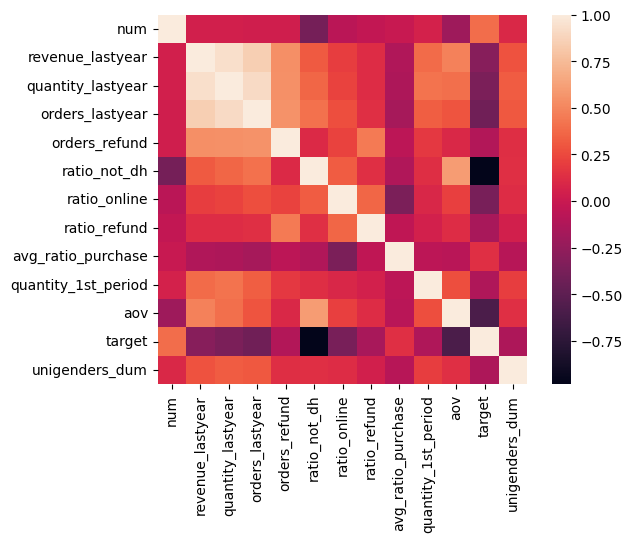

In [12]:
# отрисовываем квадратную матрицу с лейблами на осях
sns.heatmap(corr_1, square = True, xticklabels = df_2.columns, yticklabels = df_2.columns)

In [13]:
# найдём значения колонок для 2% и 98% квантиля (примем их как границы выборки)  
bounds = {
    c: dict(
        zip(["q1", "q3"], df_2.approxQuantile(c, [0.02, 0.98], 0))
    )
    for c in df_2.columns
}
bounds

{'num': {'q1': 2.0, 'q3': 14.0},
 'revenue_lastyear': {'q1': 0.0, 'q3': 187515.0},
 'quantity_lastyear': {'q1': 0.0, 'q3': 17.0},
 'orders_lastyear': {'q1': 0.0, 'q3': 9.0},
 'orders_refund': {'q1': 0.0, 'q3': 1.0},
 'ratio_not_dh': {'q1': 0.0, 'q3': 1.0},
 'ratio_online': {'q1': 0.0, 'q3': 1.0},
 'ratio_refund': {'q1': 0.0, 'q3': 0.5},
 'avg_ratio_purchase': {'q1': 0.44444444444444436, 'q3': 1.0},
 'quantity_1st_period': {'q1': 1.0, 'q3': 9.0},
 'aov': {'q1': 0.0, 'q3': 43786.5},
 'target': {'q1': 0.0, 'q3': 1.0},
 'unigenders_dum': {'q1': 0.0, 'q3': 1.0}}

In [14]:
# граничные значения выборки для столбцов с учётом iqr
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
bounds

{'num': {'q1': 2.0, 'q3': 14.0, 'lower': -16.0, 'upper': 32.0},
 'revenue_lastyear': {'q1': 0.0,
  'q3': 187515.0,
  'lower': -281272.5,
  'upper': 468787.5},
 'quantity_lastyear': {'q1': 0.0, 'q3': 17.0, 'lower': -25.5, 'upper': 42.5},
 'orders_lastyear': {'q1': 0.0, 'q3': 9.0, 'lower': -13.5, 'upper': 22.5},
 'orders_refund': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5},
 'ratio_not_dh': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5},
 'ratio_online': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5},
 'ratio_refund': {'q1': 0.0, 'q3': 0.5, 'lower': -0.75, 'upper': 1.25},
 'avg_ratio_purchase': {'q1': 0.44444444444444436,
  'q3': 1.0,
  'lower': -0.388888888888889,
  'upper': 1.8333333333333335},
 'quantity_1st_period': {'q1': 1.0, 'q3': 9.0, 'lower': -11.0, 'upper': 21.0},
 'aov': {'q1': 0.0, 'q3': 43786.5, 'lower': -65679.75, 'upper': 109466.25},
 'target': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'upper': 2.5},
 'unigenders_dum': {'q1': 0.0, 'q3': 1.0, 'lower': -1.5, 'u

In [15]:
# убираем значения в колонках, ниже нижней и выше верхней границ
df_new = df_2
for col in df_2.columns: 
    df_new = (df_new.filter(F.col(col) > bounds[col]['lower'])
             .filter(F.col(col) < bounds[col]['upper']))
    print(col)

num
revenue_lastyear
quantity_lastyear
orders_lastyear
orders_refund
ratio_not_dh
ratio_online
ratio_refund
avg_ratio_purchase
quantity_1st_period
aov
target
unigenders_dum


In [52]:
df_new.toPandas().to_csv('mycsv.csv')

In [4]:
df_new = spark.read.format('csv').option('header', 'true').load('D://ML-jupyter-main/mycsv.csv', inferSchema =True)

<AxesSubplot: >

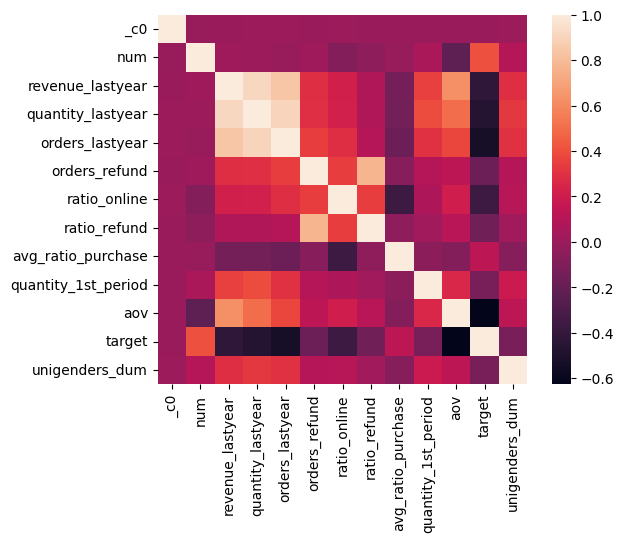

In [9]:
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=df_reg.columns, outputCol=vector_col)
df_vector = assembler.transform(df_reg).select(vector_col)

matrix = Correlation.corr(df_vector, vector_col)

corr = matrix.collect()[0]["pearson({})".format(vector_col)].values
corr_1 = corr.reshape(int(len(corr)**0.5), int(len(corr)**0.5))
sns.heatmap(corr_1, square = True, xticklabels = df_reg.columns, yticklabels = df_reg.columns)

In [8]:
df_reg = df_new.drop('ratio_not_dh')

In [10]:
# подготовка фичей в вектор
assembler = VectorAssembler(inputCols = df_reg.columns, outputCol = 'features')
output = assembler.transform(df_reg)
output.show(2, vertical=True, truncate=False)

-RECORD 0------------------------------------------------------
 _c0                 | 0                                       
 num                 | 9                                       
 revenue_lastyear    | 0.0                                     
 quantity_lastyear   | 0                                       
 orders_lastyear     | 0                                       
 orders_refund       | 0                                       
 ratio_online        | 0.0                                     
 ratio_refund        | 0.0                                     
 avg_ratio_purchase  | 1.0                                     
 quantity_1st_period | 2.0                                     
 aov                 | 0.0                                     
 target              | 1                                       
 unigenders_dum      | 0.0                                     
 features            | (13,[1,8,9,11],[9.0,1.0,2.0,1.0])       
-RECORD 1-------------------------------

In [11]:
# скалирование
scaler = StandardScaler(inputCol='features', outputCol="scaledFeatures",
                                withStd=True, withMean=True)
scalerModel = scaler.fit(output)
scaledData = scalerModel.transform(output)
scaledData.show(2, vertical = True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 _c0                 | 0                                                                                                                                                                                                                                                                     
 num                 | 9                                                                                                                                                                                                                                                                     
 revenue_lastyear    | 0.0                                                                                                                    

In [32]:
# нормализация
from pyspark.ml.feature import Normalizer
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0)
l1NormData = normalizer.transform(scaledData)
l1NormData.show(1, vertical = True, truncate=False)

-RECORD 0------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 _c0                 | 0                                                                                                                                                                                                                                                                     
 num                 | 9                                                                                                                                                                                                                                                                     
 revenue_lastyear    | 0.0                                                                                                                    

In [33]:
# масштабирование 0-1
from pyspark.ml.feature import MinMaxScaler
scaler = MinMaxScaler(inputCol="features", outputCol="scaledMinMaxFeatures")
scalerModel = scaler.fit(l1NormData)
scaledData = scalerModel.transform(l1NormData)
scaledData.show(1, vertical = True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 _c0                  | 0                                                                                                                                                                                                                                                                     
 num                  | 9                                                                                                                                                                                                                                                                     
 revenue_lastyear     | 0.0                                                                                                                

In [34]:
# масштабирование -1-1
from pyspark.ml.feature import MaxAbsScaler
scaler = MaxAbsScaler(inputCol="features", outputCol="scaledAbsFeatures")
scalerModel = scaler.fit(scaledData)
scaledData = scalerModel.transform(scaledData)
scaledData.show(2, vertical = True, truncate=False)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 _c0                  | 0                                                                                                                                                                                                                                                                     
 num                  | 9                                                                                                                                                                                                                                                                     
 revenue_lastyear     | 0.0                                                                                                                

In [35]:
scaledData.toPandas().to_csv('scaledData.csv')

In [ ]:
## КЛАССИФИКАЦИЯ

In [5]:
# какие-то данные, посмотрим
df_new.show(1, vertical = True)

-RECORD 0------------------
 _c0                 | 0   
 num                 | 9   
 revenue_lastyear    | 0.0 
 quantity_lastyear   | 0   
 orders_lastyear     | 0   
 orders_refund       | 0   
 ratio_not_dh        | 0.0 
 ratio_online        | 0.0 
 ratio_refund        | 0.0 
 avg_ratio_purchase  | 1.0 
 quantity_1st_period | 2.0 
 aov                 | 0.0 
 target              | 1   
 unigenders_dum      | 0.0 
only showing top 1 row



In [6]:
# индексируем целевую колонку, вход - название целевой колонки, выход - индексы по датафрейму
labelIndexer = StringIndexer(inputCol="target", outputCol="indexedLabel").fit(df_new)

In [7]:
# векторизуем фичи, для этого выберем и подадим нужные колонки на вход
assembler = VectorAssembler(inputCols = df_new.drop('target', 'ratio_not_dh', '_c0').columns, outputCol = 'features')
output = assembler.transform(df_new)
output.show(2, vertical=True, truncate=False)

-RECORD 0-----------------------------------------
 _c0                 | 0                          
 num                 | 9                          
 revenue_lastyear    | 0.0                        
 quantity_lastyear   | 0                          
 orders_lastyear     | 0                          
 orders_refund       | 0                          
 ratio_not_dh        | 0.0                        
 ratio_online        | 0.0                        
 ratio_refund        | 0.0                        
 avg_ratio_purchase  | 1.0                        
 quantity_1st_period | 2.0                        
 aov                 | 0.0                        
 target              | 1                          
 unigenders_dum      | 0.0                        
 features            | (11,[0,7,8],[9.0,1.0,2.0]) 
-RECORD 1-----------------------------------------
 _c0                 | 1                          
 num                 | 7                          
 revenue_lastyear    | 0.0     

In [8]:
# индексируем все фичи. Колонки, в которых кол-во различных значений <=3 считаются категориальными и разносятся
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=3).fit(output)

In [9]:
# оставим только 2 нужные колонки - с векторами фичей и целевую 
data = output.select(F.col('target'), F.col('features'))
data.show(1, vertical=True, truncate=False)

-RECORD 0------------------------------
 target   | 1                          
 features | (11,[0,7,8],[9.0,1.0,2.0]) 
only showing top 1 row



In [10]:
# сплитим данные на тестовые и тренировочные 20 и 80% соотв
(trainingData, testData) = data.randomSplit([0.8, 0.2])

In [42]:
# инициализируем классификатор градиентного бустинга, задаём число итераций обучения
gbt = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", maxIter=5)

In [12]:
# пайплайн из индексеров и классификатора. По мне бесполезная строка кода, но без неё никак
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

In [13]:
# фитим данные в пайплайн - обучаем
model = pipeline.fit(trainingData)

In [14]:
# предсказываем тестовый датафрейм, добавляя колонку предсказаний
predictions = model.transform(testData)

In [18]:
# смотрим что содержат данне
predictions.show(5)

+------+--------------------+------------+--------------------+--------------------+--------------------+----------+
|target|            features|indexedLabel|     indexedFeatures|       rawPrediction|         probability|prediction|
+------+--------------------+------------+--------------------+--------------------+--------------------+----------+
|     0|[2.0,600.0,1.0,1....|         0.0|[2.0,600.0,1.0,1....|[1.16967390812512...|[0.91208380260475...|       0.0|
|     0|[2.0,600.0,1.0,1....|         0.0|[2.0,600.0,1.0,1....|[1.16967390812512...|[0.91208380260475...|       0.0|
|     0|[2.0,1200.0,2.0,1...|         0.0|[2.0,1200.0,2.0,1...|[1.16967390812512...|[0.91208380260475...|       0.0|
|     0|[2.0,1980.0,1.0,1...|         0.0|[2.0,1980.0,1.0,1...|[1.16967390812512...|[0.91208380260475...|       0.0|
|     0|[2.0,1980.0,1.0,1...|         0.0|[2.0,1980.0,1.0,1...|[1.16967390812512...|[0.91208380260475...|       0.0|
+------+--------------------+------------+--------------------+-

In [19]:
# проверка на наличие обоих классов в предсказаниях
predictions.groupby('prediction').count().show(2)

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|35465|
|       1.0|23829|
+----------+-----+



In [20]:
# определяем оценщик, куда прописываем истинные лейблы и предсказанные, выбираем метрику - точность
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

Test Error = 0.00148413


In [21]:
# посмотрим на структуру классификатора
gbtModel = model.stages[2]
print(gbtModel)

GBTClassificationModel: uid = GBTClassifier_a578c4087333, numTrees=5, numClasses=2, numFeatures=11


In [22]:
# тоже оцнщик, только метрика f1
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="f1")
f1 = evaluator.evaluate(predictions)
print(f1)

0.9985154241751845


In [23]:
# оценщик по аук метрике
eval_auc = BinaryClassificationEvaluator(labelCol="indexedLabel", rawPredictionCol="prediction")

In [24]:
# значение аук метрики
auc = eval_auc.evaluate(predictions)
print(auc)

0.9981603043860016


In [ ]:
# ФИЧ ЭКСТРАКТИНГ. Метод не может быть применён к пайплайну, так что придётся переобучить модель напрямую

In [45]:
# инициализируем классификатор, указываем колонки с лэйблами и фичами
gbt = GBTClassifier(labelCol="target", featuresCol="features", maxIter=5)

In [ ]:
# обучаем напрямую
model = gbt.fit(trainingData)

In [44]:
# применяем метод для определения веса фичей в модели. Больше вес - большее влияние фича оказала на снижение неопределённости
# при обучении классификатора
model.featureImportances

SparseVector(11, {0: 0.0002, 1: 0.5812, 2: 0.0818, 3: 0.3367, 4: 0.0, 5: 0.0, 8: 0.0, 9: 0.0001, 10: 0.0})

In [ ]:
# revenue_lastyear - оказала большее влияние на снижение неопределённости при классификации объектов